In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import distance
from scipy import stats
from scipy.stats import norm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader

plt.rcParams['figure.figsize'] = [10, 8]
sns.set_style('darkgrid')

In [2]:
dataset = pd.read_csv('/kaggle/input/irisdataset/Iris.csv')
dataset = dataset.drop(columns=['Id'])
FEATURES_LIST = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']
X = dataset[FEATURES_LIST].values
Y = dataset[['Species']]
encoder = LabelEncoder()
Y = encoder.fit_transform(Y['Species'])

test_size = 0.5
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=0)

In [3]:
def get_unique_adjacent_means(arr):
    # The line below takes mean of every adjacent value
    # example: if the input value is     : [1, 2, 3, 4, 5]
    # the return value of this method is : [1.5, 2.5, 3.5, 4.5]
    return np.convolve(np.unique(arr), [0.5, 0.5], 'valid')

def get_gini_impurity(arr):
    _, counts = np.unique(arr, return_counts=True)
    counts = counts / counts.sum()
    squared_sum = (counts ** 2).sum()
    return 1 - squared_sum

def get_best_criterion(x, y):
    assert(len(x.shape) == 1)
    assert(len(y.shape) == 1)
    sorted_indices = np.argsort(x)
    x = x[sorted_indices]
    y = y[sorted_indices]
    labels = np.unique(y)
    least_gini_impurity = float('inf')
    best_threshold = None
    thresholds = get_unique_adjacent_means(x)
    for threshold in thresholds:
        left = x <= threshold
        right = x > threshold
        y_left, y_right = y[left], y[right]
        y_left_gini_impurity, y_right_gini_impurity = get_gini_impurity(y_left), get_gini_impurity(y_right)
        total_gini_impurity = (len(y_left) * y_left_gini_impurity + len(y_right) * y_right_gini_impurity) / len(y)
        # print(y_left_gini_impurity, y_right_gini_impurity, total_gini_impurity)
        if total_gini_impurity < least_gini_impurity:
            least_gini_impurity = total_gini_impurity
            best_threshold = threshold
    return best_threshold, least_gini_impurity

def get_best_split(X, Y):
    n_cols = len(X[0])
    least_gini_value = float('inf')
    best_col = None
    best_col_threshold = None
    for i in range(n_cols):
        col = X[:, i].ravel()
        threshold, gini_value = get_best_criterion(col, Y)
        # print(f'For column {i}, threshold is {threshold} and gini_value is {gini_value}')
        if gini_value < least_gini_value:
            least_gini_value = gini_value
            best_col = i
            best_col_threshold = threshold
    # print(f'$$$$$$$$ Best split is obtained using col #{best_col} where gini impurity is {least_gini_value} and threshold is {best_col_threshold}')    
    left = X[:, best_col] <= best_col_threshold
    right = ~left
    # print(left)
    X_left, X_right = X[left, :], X[right, :]
    Y_left, Y_right = Y[left], Y[right]
    
    return (X_left, X_right, Y_left, Y_right), (best_col, best_col_threshold)

In [4]:
class DecisionTreeBase():
    def __init__(self, X, Y):
        self._left = None
        self._right = None
        self._is_leaf = None
        self._leaf_label = None
        self._best_col = None
        self._best_threshold = None
        labels_count = np.unique(Y)

        if len(labels_count) == 1:
            self._is_leaf = True
            self._leaf_label = Y[0]
            return

        ((X_left, X_right, Y_left, Y_right), (best_col, best_col_threshold)) = get_best_split(X, Y)
        self._best_col = best_col
        self._best_threshold = best_col_threshold
        self._right = DecisionTreeBase(X_right, Y_right)
        self._left  = DecisionTreeBase(X_left, Y_left)

    def predict(self, x):
        if self._is_leaf:
            return self._leaf_label
        elif x[self._best_col] <= self._best_threshold:
            return self._left.predict(x)
        else:
            return self._right.predict(x)

class DecisionTreeClassifier():
    def __init__(self):
        self._X = None
        self._Y = None

    def fit(self, X, Y):
        self.validate_input(X)
        self._X = X
        self._Y = Y
        self._model = DecisionTreeBase(X, Y)
        
    def predict(self, X):
        self.validate_input(X)
        predictions = []
        for x in X:
            predictions.append(self._model.predict(x))
        return np.array(predictions)
    
    def score(self, x, y):
        return np.mean(self.predict(x) == y)

    def validate_input(self, x):
        x_shape = x.shape
        assert len(x_shape) == 2, f'Invalid shape obtained for X : {x_shape}'

In [5]:
# Sample dataset for debugging purpose
"""
dataset = np.array([
    [1, 1, 0, 0, 1, 1, 0],
    [1, 0, 1, 1, 1, 0, 0],
    [7, 12, 18, 35, 38, 50, 83]
]).T
labels = np.array([0, 0, 1, 1, 1, 0, 0])

print(dataset)
print(labels)
"""

'\ndataset = np.array([\n    [1, 1, 0, 0, 1, 1, 0],\n    [1, 0, 1, 1, 1, 0, 0],\n    [7, 12, 18, 35, 38, 50, 83]\n]).T\nlabels = np.array([0, 0, 1, 1, 1, 0, 0])\n\nprint(dataset)\nprint(labels)\n'

In [6]:
def traverse_decision_tree(decision_tree):
    print(f'Node info - {decision_tree._best_col} | {decision_tree._best_threshold}')
    if not decision_tree._is_leaf:
        traverse_decision_tree(decision_tree._right)
        traverse_decision_tree(decision_tree._left)

In [7]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
clf.predict(X_test)

array([2, 1, 0, 2, 0, 2, 0, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 1, 0, 0, 2, 1,
       0, 0, 2, 0, 0, 1, 1, 0, 2, 1, 0, 2, 2, 1, 0, 2, 1, 1, 2, 0, 2, 0,
       0, 1, 2, 2, 1, 2, 1, 2, 1, 1, 2, 2, 1, 2, 1, 2, 1, 0, 2, 1, 1, 1,
       1, 2, 0, 0, 2, 1, 0, 0, 1])

In [8]:
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

1.0
0.96


In [9]:
from sklearn.tree import DecisionTreeClassifier as DecisionTreeClassifierSklearn
clf_sklearn = DecisionTreeClassifierSklearn()
clf_sklearn.fit(X_train, y_train)
clf_sklearn.predict(X_test)

array([2, 1, 0, 2, 0, 2, 0, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 1, 0, 0, 2, 1,
       0, 0, 2, 0, 0, 1, 1, 0, 2, 1, 0, 2, 2, 1, 0, 2, 1, 1, 2, 0, 2, 0,
       0, 1, 2, 2, 1, 2, 1, 2, 1, 1, 2, 2, 1, 2, 1, 2, 1, 0, 2, 1, 1, 1,
       1, 2, 0, 0, 2, 1, 0, 0, 1])

In [10]:
print(clf_sklearn.score(X_train, y_train))
print(clf_sklearn.score(X_test, y_test))

1.0
0.96


In [11]:
def create_bootstrapped_dataset(X, Y):
    indices = list(range(len(X)))
    chosen_indices = np.random.choice(indices, len(X))
    X_subset = X[chosen_indices]
    Y_subset = Y[chosen_indices]
    oob_indices = list(set(indices) - set(chosen_indices))
    oob_X = X[oob_indices]
    oob_Y = Y[oob_indices]
    return (X_subset, Y_subset), (oob_X, oob_Y)

class RandomForest():
    def __init__(self, n_estimators=10):
        self._n_estimators = n_estimators
        self._dt_clfs = []

    def fit(self, X, Y):
        for i in range(self._n_estimators):
            # Create a bootstrapped dataset
            ((X_subset, Y_subset), _) = create_bootstrapped_dataset(X, Y)
            clf = DecisionTreeClassifier()
            clf.fit(X_subset, Y_subset)
            self._dt_clfs.append(clf)
    
    def predict(self, X):
        predictions = []
        for clf in self._dt_clfs:
            predictions.append(clf.predict(X))
        predictions = np.array(predictions)
        return stats.mode(predictions, axis=0)[0].ravel()
    
    def score(self, x, y):
        return np.mean(self.predict(x) == y)

    def validate_input(self, x):
        x_shape = x.shape
        assert len(x_shape) == 2, f'Invalid shape obtained for X : {x_shape}'

For random forest with n_estimators = 1, train accuracy obtained is: 0.9867 and test accuracy obtained is: 0.9333
For random forest with n_estimators = 2, train accuracy obtained is: 1.0000 and test accuracy obtained is: 0.9600
For random forest with n_estimators = 3, train accuracy obtained is: 0.9867 and test accuracy obtained is: 0.9067
For random forest with n_estimators = 4, train accuracy obtained is: 0.9867 and test accuracy obtained is: 0.9067
For random forest with n_estimators = 5, train accuracy obtained is: 0.9867 and test accuracy obtained is: 0.9600
For random forest with n_estimators = 6, train accuracy obtained is: 0.9867 and test accuracy obtained is: 0.8800
For random forest with n_estimators = 7, train accuracy obtained is: 0.9867 and test accuracy obtained is: 0.9067
For random forest with n_estimators = 8, train accuracy obtained is: 0.9867 and test accuracy obtained is: 0.9067
For random forest with n_estimators = 9, train accuracy obtained is: 1.0000 and test acc

,n_estimators,scores
0,1,0.933333
1,2,0.960000
2,3,0.906667
3,4,0.906667
4,5,0.960000
5,6,0.880000
6,7,0.906667
7,8,0.906667
8,9,0.960000
9,10,0.920000


Text(0.5, 1.0, 'Accuracy score vs n_estimators (Random Forest)')

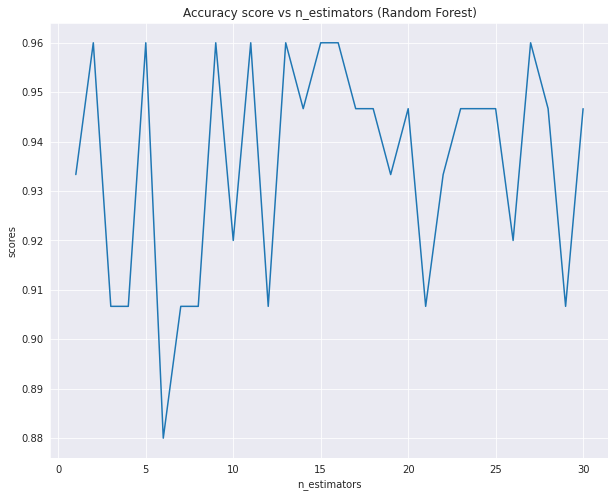

In [12]:
max_n_estimators = 30
scores = []
for n_estimators in range(1, max_n_estimators + 1):
    rfclf = RandomForest(n_estimators=n_estimators)
    rfclf.fit(X_train, y_train)
    train_score = rfclf.score(X_train, y_train)
    score = rfclf.score(X_test, y_test)
    print(f'For random forest with n_estimators = {n_estimators}, train accuracy obtained is: {train_score:.4f} and test accuracy obtained is: {score:.4f}')
    scores.append(score)
df = pd.DataFrame({'n_estimators': list(range(1, max_n_estimators + 1)), 'scores': scores})
display(df)
ax = sns.lineplot(data=df, x='n_estimators', y='scores')
ax.set_title('Accuracy score vs n_estimators (Random Forest)')

For random forest with n_estimators = 1, train accuracy obtained is: 0.9867 and test accuracy obtained is: 0.9200
For random forest with n_estimators = 2, train accuracy obtained is: 0.9867 and test accuracy obtained is: 0.9067
For random forest with n_estimators = 3, train accuracy obtained is: 1.0000 and test accuracy obtained is: 0.9333
For random forest with n_estimators = 4, train accuracy obtained is: 0.9733 and test accuracy obtained is: 0.9067
For random forest with n_estimators = 5, train accuracy obtained is: 0.9733 and test accuracy obtained is: 0.9600
For random forest with n_estimators = 6, train accuracy obtained is: 0.9867 and test accuracy obtained is: 0.9067
For random forest with n_estimators = 7, train accuracy obtained is: 1.0000 and test accuracy obtained is: 0.9200
For random forest with n_estimators = 8, train accuracy obtained is: 1.0000 and test accuracy obtained is: 0.9467
For random forest with n_estimators = 9, train accuracy obtained is: 1.0000 and test acc

,n_estimators,scores
0,1,0.920000
1,2,0.906667
2,3,0.933333
3,4,0.906667
4,5,0.960000
5,6,0.906667
6,7,0.920000
7,8,0.946667
8,9,0.946667
9,10,0.920000


Text(0.5, 1.0, 'Accuracy score vs n_estimators (Random Forest, sklearn)')

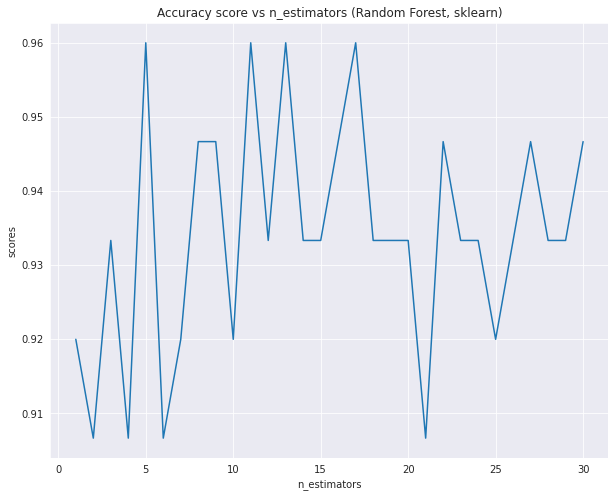

In [13]:
from sklearn.ensemble import RandomForestClassifier

max_n_estimators = 30
scores = []
for n_estimators in range(1, max_n_estimators + 1):
    rfclf = RandomForestClassifier(n_estimators=n_estimators)
    rfclf.fit(X_train, y_train)
    train_score = rfclf.score(X_train, y_train)
    score = rfclf.score(X_test, y_test)
    print(f'For random forest with n_estimators = {n_estimators}, train accuracy obtained is: {train_score:.4f} and test accuracy obtained is: {score:.4f}')
    scores.append(score)
df = pd.DataFrame({'n_estimators': list(range(1, max_n_estimators + 1)), 'scores': scores})
display(df)
ax = sns.lineplot(data=df, x='n_estimators', y='scores')
ax.set_title('Accuracy score vs n_estimators (Random Forest, sklearn)')